In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import copy

#from scipy.optimize import leastsq # Levenberg-Marquadt Algorithm
from scipy.optimize import curve_fit

In [47]:
# load data
a='fit_example.h5'    #0,270  #frame 2500
b='fit_example2.h5'   #0,45,135,225,270,315  #frame 3000
c='fit_example3.h5'

output_path='/data/visitors/nanomax/20190570/2019041008/process/as_deposited_2nd_indent_no_load/'

#with h5py.File(output_path+b,'r') as h5f:
#    q_array = h5f["/entry/integ/q"][()]
#    integration_array = h5f["/entry/integ/intensity"][()]
#    sigma_array = h5f["/entry/integ/sigma"][()]

with h5py.File(output_path+c,'r') as h5f:
    q_array = h5f["/entry/integ/q"][()]
    integration_array = h5f["/entry/integ/data"][()]
    sigma_array = h5f["/entry/integ/sigma"][()]
    #azimuth_array=h5f["/entry/integ/azimuth_range"][()]


print(q_array.shape)
print(integration_array.shape)
 
    

(1, 1800)
(1, 1800)


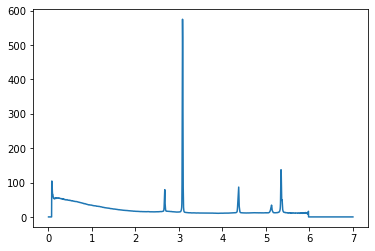

In [48]:
# plot data
irow = 0
plt.plot(q_array[irow,:],integration_array[irow,:])
plt.show()

(0, 4)

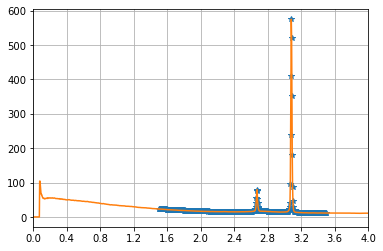

In [7]:
def select_good_data(x,y):
    lidx = y>0
    lidx = np.logical_and(lidx, np.logical_and(x>=1.5 , x<=3.5))
    return x[lidx],y[lidx]

x, y = select_good_data(q_array[irow,:],integration_array[irow,:])


fig,ax = plt.subplots(1,1)
plt.plot(x,y,'*', q_array[irow,:],integration_array[irow,:],'-')
plt.grid(axis='both',which='both')
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=0.4) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

plt.xlim((0,4))

In [49]:
# model functions for diffraction line fitting
def gaussian(x,p):
    y = np.log(2.) * ( (x - p[1])/(0.5*p[2]) )**2
    y = p[0]*np.exp(-y)
    y =  y * 2.*np.sqrt(np.log(2.)/np.pi)/p[2]
    return y

def lorentzian(x,p):
    y = (x - p[1])/(0.5*p[2])
    y = p[0]/(1.+y**2)
    y =  y * 2./np.pi/p[2]
    return y

# (multi-peak) pseudoVoigth function
# parameters = [integI, position, fwhm, LorentzianContent]
# one raw of output matrix per parameters line (one peak in each raw)
# you can sum them by numpy.sum(pseudoVoigt(x,p),0)
def pseudoVoigt(x,p):
    a = np.array(p)
    m = int(a.size / 4)
    a = a.reshape(m,4)
    y = np.zeros((m,len(x)),dtype=np.float)
    for k in range(0,m):
        if np.absolute(a[k,0])>0.:
            y[k] = (1.-a[k,3])*gaussian(x,a[k,0:3])+a[k,3]*lorentzian(x,a[k,0:3])
    return y

nbkg_params = 5 # number of bkg parameters

# model - multiple pseudovoigt with quadratic background
def model1(x,*p):
    global nbkg_params
    y = np.sum(pseudoVoigt(x,p[0:-nbkg_params]),0)
    y = y + p[-5]/x + p[-4]*x**3 + p[-3]*x**2 + p[-2]*x + p[-1]
    return y

def full_param_set(p,p0,l0):
    l0 = [item for sublist in l0 for item in sublist]
    lindp = np.array(l0)==1 # logical index
    pp = p0.copy()
    pp[lindp] = np.array(p)[()]
    return pp

def curve_fit_wrap(model,x,y,p0,l0,sigma,absolute_sigma,bounds,maxfev,method='trf'):
    def _model(x,*p):
        pp = p0.copy()
        pp[lindp] = np.array(p)[()]
        y = model(x,*pp)
        return y
    l0 = [item for sublist in l0 for item in sublist]
    lindp = np.array(l0)==1 # logical index
    pp = p0[lindp] # eliminate parameters that we do not want to fit
    bounds = (np.asarray(bounds[0])[lindp].tolist(),np.asarray(bounds[1])[lindp].tolist())
    p1, pcov = curve_fit(_model,x,y,pp,sigma=sigma,absolute_sigma=absolute_sigma,bounds=bounds,maxfev=maxfev,method=method)
    return p1, pcov


def build_bounds(p,qpos=np.inf,qrwidth=np.inf):
    p_min = []
    p_max = []
    # peak bounds
    for i in range(p.size-nbkg_params):
        pn = i % 4
        if (pn==0):
            # intensity
            p_min = p_min + [0.]
            p_max = p_max + [np.inf]
        elif (pn==1):
            # position
            p_min = p_min + [p[i]-qpos/2]
            p_max = p_max + [p[i]+qpos/2]
        elif (pn==2):
            # width
            p_min = p_min + [0.]
            p_max = p_max + [p[i]*qrwidth]
        elif (pn==3):
            # shape
            p_min = p_min + [0.]
            p_max = p_max + [1.]
        else:
            pass
    # background bounds
    # 1/x
    p_min = p_min + [-np.inf]
    p_max = p_max + [ np.inf]
    # polynomial
    for i in range(nbkg_params-1):
        p_min = p_min + [-np.inf]
        p_max = p_max + [np.inf]
    return (p_min,p_max)

0
Warning! Some TiAlN peaks are fixed.
Warning! Some h-Aln peaks are fixed.
[[1.54926340e-07 2.53099838e+00 5.68580646e-07 2.08407493e-05]
 [5.38693763e+00 2.69400000e+00 7.30585018e-01 9.99999996e-01]
 [1.32088134e+00 2.67164456e+00 1.57151458e-02 6.31464969e-01]
 [1.00585452e+01 3.08334819e+00 1.53629179e-02 2.66740678e-01]
 [0.00000000e+00 3.34500000e+00 1.70000000e-02 0.00000000e+00]
 [2.19525204e+00 4.36808313e+00 2.77531899e-02 3.53662969e-01]
 [7.30966552e-01 5.12314005e+00 3.63912045e-02 1.88049630e-03]
 [3.49730678e+00 5.34834929e+00 1.78483835e-02 9.26859718e-01]
 [0.00000000e+00 2.56100000e+00 1.76900000e-02 1.83000000e-01]
 [0.00000000e+00 2.95700000e+00 2.92690000e-02 7.40000000e-01]
 [0.00000000e+00 4.18000000e+00 2.92690000e-02 7.40000000e-01]
 [0.00000000e+00 4.90000000e+00 2.92690000e-02 7.40000000e-01]
 [0.00000000e+00 5.91500000e+00 2.92690000e-02 7.40000000e-01]
 [0.00000000e+00 1.00000000e+00 2.92690000e-02 7.40000000e-01]
 [0.00000000e+00 1.70000000e+00 2.92690000

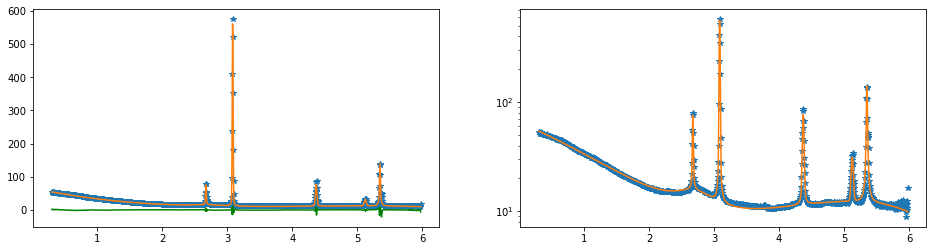

In [68]:
# fitting

def select_good_data(x,y):
    lidx = y>0
    #lidx = np.logical_and(lidx, np.logical_and(x>=2.4 , x<=2.8))
    #lidx = np.logical_and(lidx, np.logical_and(x>=4.0 , x<=5.0))
    # first good
    idx1 = np.where(lidx)[0][0]
    # last good
    idx2 = np.where(lidx)[0][-1]
    lidx = np.logical_and(lidx, np.logical_and(x>=x[idx1] , x<=x[idx2]))
    # above 0.3
    lidx = np.logical_and(lidx,x>=0.3)
    # return result
    return x[lidx],y[lidx]

#irow = 0
print(irow)

xx, yy = select_good_data(q_array[irow,:],integration_array[irow,:])
ss = np.sqrt(yy)

#plt.figure(figsize=(16, 4))
#plt.plot(xx,ss,'-',xx,sspyf,'*')
#plt.show()

#plt.figure()
#plt.plot(xx,ss,'o',xx,ssy,'*')
#plt.show()

# estimate background
y0 = np.mean(yy[0:5])  #0:5
y1 = np.mean(yy[-5:])
b1 = (y1-y0)/(xx[-1]-xx[0]) # slope
b0 = y0 -b1*xx[0] # offset
# initial parameters


l0 = [[ 1, 1, 1, 1], # 2.506  1 1 1 0 small   *111  TiAlN     0   #changed from 1 0 0 0
      [ 1, 1, 1, 1], # 2.669  1 1 1 0 diffuse  111  TiAlN     1
      [ 1, 1, 1, 1], # 2.669  1 1 1 1 strong   111  TiAlN     2
      [ 1, 1, 1, 1], # 3.076  1 1 1 1 strong   200  TiAlN     3
      [ 1, 0, 0, 0], # 3.345  1 1 1 1 small   *     TiAlN     4
      [ 1, 1, 1, 1], # 4.354  1 1 1 1 strong   220  TiAlN     5
      [ 1, 1, 1, 1], # 5.116  1 1 1 1 strong   311  TiAlN     6
      [ 1, 1, 1, 1], # 5.345  1 1 1 1 strong   222  TiAlN     7
      [ 1, 1, 1, 1], # 2.561  1 1 1 1 strong   111  TiN       8
      [ 1, 1, 1, 1], # 2.957  1 1 1 1 strong   200  TiN       9
      [ 1, 1, 1, 1], # 4.18   1 1 1 1          220  TiN (or a deep sub?) 10
      [ 1, 1, 1, 1], # 4.90   1 1 1 1          331  TiN       11
      [ 1, 1, 1, 1], # 5.915  1 1 1 1          400  TiN       12
      [ 1, 1, 0, 0], # deep sub                               13
      [ 1, 1, 0, 0], # deep sub                               14
      [ 1, 1, 1, 1], #100 h-AlN                               15
      [ 1, 1, 1, 1], #002 h-AlN                               16
      [ 1, 1, 1, 1], #101 h-AlN                               17
      [ 1, 1, 1, 1], #102 h-AlN                               18
      [ 1, 1, 1, 1], #110 h-AlN                               19
      [ 1, 1, 1, 1], #103 h-AlN                               20
      [ 1, 1, 1, 1], #200 h-AlN                               21
      [ 1, 1, 1, 1], #112 h-AlN                               22
      [ 1, 1, 1, 1], #201 h-AlN                               23
      [ 1, 1, 1, 1], #004 h-AlN                               24
      [ 1, 1, 1, 1], #202 h-AlN                               25
      [ 1, 1, 1, 1], #104 h-AlN                               26
      [ 1, 1, 1, 1], #203 h-AlN                               27
      [ 1, 1, 1, 1], #210 h-AlN                               28
      [ 1,1,1,1,1]] # backgrounfrom multiprocessing import Pool

p0 = [[0.2, 2.506, 0.02, 0.0], # small *111                   0
      [5.1, 2.669, 0.7, 1.0],   # diffuse 111                 1
      [5.1, 2.669, 0.014, 0.3], # strong 111                  2
      [4.3, 3.076, 0.030, 0.8], # strong 200                  3
      [0.1, 3.345, 0.017, 0.0], # small *                     4
      [1.8, 4.363, 0.035, 0.4], # strong 220                  5
      [0.6, 5.116, 0.040, 0.4], # strong 311                  6
      [0.5, 5.345, 0.040, 0.4], # strong 222                  7
      [2.161, 2.561, 0.01769, 0.183], # strong 111 TiN        8
      [5.4896, 2.957, 0.029269, 0.740], # strong 200 TiN      9
      [1.0, 4.18, 0.029269, 0.740], # TiN 220                 10
      [1.0, 4.90, 0.029269, 0.740], # TiN 311                 11 
      [2.0, 5.915, 0.029269, 0.740], # TiN 400                12  
      [1.0, 1.000, 0.029269, 0.740], # deep sub               13
      [1.0, 1.7, 0.029269, 0.740], # deep sub                 14
      [1.0, 2.328053, 0.029269, 0.740], #100 h-AlN            15
      [1.0, 2.51856, 0.029269, 0.740], #002 h-AlN             16
      [1.0, 2.644218, 0.029269, 0.740], #101 h-AlN            17
      [1.0, 3.433596, 0.029269, 0.740], #102 h-AlN            18 
      [1.0, 4.030843, 0.029269, 0.740], #110 h-AlN            19
      [1.0, 4.440065, 0.029269, 0.740], #103 h-AlN            20 
      [1.0, 4.651398, 0.029269, 0.740], #200 h-AlN            21 
      [1.0, 4.753759, 0.029269, 0.740], #112 h-AlN            22  
      [1.0, 4.821187, 0.029269, 0.740], #201 h-AlN            23 
      [1.0, 5.053125, 0.029269, 0.740], #004 h-AlN            24 
      [1.0, 5.310345, 0.029269, 0.740], #202 h-AlN            25 
      [1.0, 5.567922, 0.029269, 0.740], #104 h-AlN            26       
      [1.0, 6.012431, 0.029269, 0.740], #203 h-AlN            27 
      [1.0, 6.178472, 0.029269, 0.740], #210 h-AlN            28
     ]


 
tialn_ind = [0,1,2,3,4,5,6,7]
tin_ind = [8,9,10,11,12]
deep_sub_ind = [13,14]
aln_ind = [15,16,17,18,19,20,21,22,23,24,25,26,27,28]



#	peak	Q
#WC	001	2.213469672
#	100	2.494987346
#	101	3.335023986#
#	110	4.322084816
#	002	4.427578259
#	111	4.855742347
#		
#Co	111	3.061531074
#	200	3.531690495
#	220	5.002511151


npeaks = np.array(p0).shape[0]

# set zero intensity and fix TiAlN peaks

if (True):
    print('\033[35mWarning! Some TiAlN peaks are fixed.\033[0m')
    tialn_ind = [4,]
    for i in tialn_ind:
        for k in range(4):
            l0[i][k] = 0 # fix
            p0[i][0] = 0 # set zero intensity

                
#set zero intensity and fix deep-sub peaks
if(True):
    for i in deep_sub_ind:
        for k in range(4):
            l0[i][k] = 0 # fix
            p0[i][0] = 0 # set zero intensity

# set zero intensity and fix tin peaks
if(True):
    for i in tin_ind:
        for k in range(4):
            l0[i][k] = 0 # fix
            p0[i][0] = 0 # set zero intensity
            
if (True):
    print('\033[35mWarning! Some h-Aln peaks are fixed.\033[0m')
    for i in aln_ind:
        for k in range(4):
            l0[i][k] = 0 # fix
            p0[i][0] = 0 # set zero intensity            

# fix all peaks positions,width,shape (do not use !)
if(False):
    for k in range(npeaks):
        l0[k][1] = 0 # position
        l0[k][2] = 0 # width
        l0[k][3] = 0 # shape
        
p0 = np.concatenate((np.array(p0).reshape(npeaks*4),[0.0,0.0,0.0,b1,b0]))
perr = copy.deepcopy(p0)*0
p1 = copy.deepcopy(p0)*0
bounds = build_bounds(p0,qpos=0.05,qrwidth=2.0)
# fitting
if(True):
    # --- the 1st fit stage ---
    # fix higher order bkg coeff
    _l0 = copy.deepcopy(l0)
    _l0[-1][-(nbkg_params-1):-2] = [0]*(nbkg_params-3)
    
    # fix all peak width and shape parameter and all positions
    for k in range(npeaks):
        _l0[k][1] = 0 # position
        _l0[k][2] = 0 # width
        _l0[k][3] = 0 # shape
    p1, pcov = curve_fit_wrap(model1,xx,yy,p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100,method='trf')
    # return non-fitted parameters
    p0 = full_param_set(p1,p0,_l0)
    # --- the 2nd fit stage ---
    _l0 = copy.deepcopy(l0)
    # fix all peak width and shape parameter and all positions
    for k in range(npeaks):
        _l0[k][1] = 0 # position
        _l0[k][2] = 0 # width
        _l0[k][3] = 0 # shape
    p1, pcov = curve_fit_wrap(model1,xx,yy,p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100,method='trf')
    # return non-fitted parameters
    p0 = full_param_set(p1,p0,_l0)
    # --- the 3rd fit stage ---
    _l0 = copy.deepcopy(l0)
    _p0 = copy.deepcopy(p0)
    # fix all peak parameters, outside of range
    for k in range(npeaks):
        if ((_p0[k*4+1]>=xx[-1]) or (_p0[k*4+1]<=xx[0])):
            _l0[k][0] = 0 # intensity
            _l0[k][1] = 0 # position
            _l0[k][2] = 0 # width
            _l0[k][3] = 0 # shape
            _p0[k*4+0] = 0 # set intensity to zero
    # fix all peak width and shape parameter and all positions
    for k in range(npeaks):
        _l0[k][3] = 0 # shape
    p1, pcov = curve_fit_wrap(model1,xx,yy,_p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=100,method='trf')
    # return non-fitted parameters
    p0 = full_param_set(p1,_p0,_l0)
    # --- the 4th fit stage ---
    _l0 = copy.deepcopy(l0)
    _p0 = copy.deepcopy(p0)
    # fix all peak parameters, outside of range
    for k in range(npeaks):
        if ((_p0[k*4+1]>=xx[-1]) or (_p0[k*4+1]<=xx[0])):
            _l0[k][0] = 0 # intensity
            _l0[k][1] = 0 # position
            _l0[k][2] = 0 # width
            _l0[k][3] = 0 # shape
            _p0[k*4+0] = 0 # set intensity to zero
    p1, pcov = curve_fit_wrap(model1,xx,yy,_p0,_l0,sigma=ss,absolute_sigma=True,bounds=bounds,maxfev=500,method='trf')
    perr = np.sqrt(np.diag(pcov))
    # return non-fitted parameters
    p1 = full_param_set(p1,_p0,_l0)
    perr = full_param_set(perr,np.zeros(p1.shape),_l0)
    yyc = model1(xx,*p1)
else:
    # not fitting
    p1 = copy.deepcopy(p0)
    yyc = model1(xx,*p0)
    
    
# plot data
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(xx,yy,"*")
plt.plot(xx,yyc,"-")
plt.plot(xx,yyc-yy,"g-")
plt.subplot(122)
plt.semilogy(xx,yy,"*")
plt.semilogy(xx,yyc,"-")

#plt.xlim((5.0,6.0))

print( np.array(p1[:-nbkg_params]).reshape(npeaks,4) )
print( p1[-nbkg_params:] )

peak_p = np.array(p1[:-nbkg_params]).reshape(npeaks,4)
peak_ep = np.array(perr[:-nbkg_params]).reshape(npeaks,4)

In [ ]:
print( np.array(perr[:-nbkg_params]).reshape(npeaks,4) )

In [ ]:
hkl_l = [[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0]]
Qhkl = np.zeros((len(hkl_l),))
apar = 4.09 # (A)
for k in range(len(hkl_l)):
    hkl = np.asarray(hkl_l[k])
    Qhkl[k] = 2*np.pi/apar*np.sqrt(np.dot(hkl,hkl))
    print("TiAlN %d %d %d    %f" % (hkl[0],hkl[1],hkl[2],Qhkl[k]))
    
hkl_l = [[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0]]
Qhkl = np.zeros((len(hkl_l),))
apar = 4.249 # (A)  #Magnus 4.2
for k in range(len(hkl_l)):
    hkl = np.asarray(hkl_l[k])
    Qhkl[k] = 2*np.pi/apar*np.sqrt(np.dot(hkl,hkl))
    print("TiN %d %d %d    %f" % (hkl[0],hkl[1],hkl[2],Qhkl[k]))    
    

In [ ]:
peak_ep